In [113]:
from imp import load_source
from pyexpat import features

import pandas as pd

df_train = pd.read_csv('/Users/baymax/Code/pythonProject/PRML/hw3/data/LSTM-Multivariate_pollution.csv')
print(df_train.head())
print(df_train.dtypes)
print(df_train.isnull().sum())

                  date  pollution  dew  temp   press wnd_dir  wnd_spd  snow  \
0  2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0   
1  2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0   
2  2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0   
3  2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1   
4  2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2   

   rain  
0     0  
1     0  
2     0  
3     0  
4     0  
date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object
date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64


In [114]:
# data preprocessing
from sklearn.preprocessing import LabelEncoder

df_train['date'] = pd.to_datetime(df_train['date'])
le = LabelEncoder()
df_train['wnd_dir'] = le.fit_transform(df_train['wnd_dir'])
df_train.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [115]:
import numpy as np

def create_lstm_dataset(data, target_col='pollution', time_steps=3):
    X, y = [], []
    for i in range(len(data)-time_steps):
        features = data.iloc[i:(i+time_steps)].drop(columns=['date', target_col]).values
        target = data.iloc[i + time_steps][target_col]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_lstm_dataset(df_train, target_col='pollution', time_steps=7)
print(X.shape)
print(y.shape)

(43793, 7, 7)
(43793,)


In [116]:
from sklearn.model_selection import train_test_split

train_size = int(len(X)*0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [117]:
from sklearn.preprocessing import MinMaxScaler

n_features = X.shape[2]
scalers = [MinMaxScaler() for _ in range(n_features)]
for i in range(n_features):
    # 将每个特征展开成二维列向量，正确记录 min/max
    X_train_2d = X_train[:, :, i].reshape(-1, 1)  
    scalers[i].fit(X_train_2d)
    # 训练集缩放
    X_train[:, :, i] = scalers[i].transform(X_train_2d).reshape(X_train.shape[0], X_train.shape[1])
    # 验证集缩放
    X_val[:, :, i] = scalers[i].transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])

In [118]:
scalers[0].data_max_, scalers[0].data_min_

(array([28.]), array([-33.]))

In [119]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [120]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1 ,1)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1 ,1)

batch_size = 64
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [121]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [122]:
input_size = n_features
hidden_size = 64
model = LSTMModel(input_size, hidden_size, num_layers=2)

In [123]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [124]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        val_losses = []
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            val_loss = criterion(output, y_batch)
            val_losses.append(val_loss.item())
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {sum(val_losses)/len(val_losses):.4f}")

Epoch [1/50], Loss: 5302.1738, Val Loss: 12128.1663
Epoch [2/50], Loss: 6917.1465, Val Loss: 9885.7105
Epoch [3/50], Loss: 5594.0332, Val Loss: 9058.0114
Epoch [4/50], Loss: 11643.8438, Val Loss: 8826.4130
Epoch [5/50], Loss: 5950.9053, Val Loss: 8773.5796
Epoch [6/50], Loss: 6865.0918, Val Loss: 8745.6629
Epoch [7/50], Loss: 5033.7168, Val Loss: 7028.3680
Epoch [8/50], Loss: 10260.2461, Val Loss: 6607.5304
Epoch [9/50], Loss: 7981.5752, Val Loss: 6467.3053
Epoch [10/50], Loss: 6412.9707, Val Loss: 6240.7759
Epoch [11/50], Loss: 6662.2778, Val Loss: 6113.6979
Epoch [12/50], Loss: 3399.9326, Val Loss: 6105.8631
Epoch [13/50], Loss: 2999.5178, Val Loss: 5756.9829
Epoch [14/50], Loss: 4431.9019, Val Loss: 5907.1603
Epoch [15/50], Loss: 5402.1479, Val Loss: 5999.5303
Epoch [16/50], Loss: 4289.8027, Val Loss: 5743.8899
Epoch [17/50], Loss: 3647.5166, Val Loss: 5670.3117
Epoch [18/50], Loss: 4310.8281, Val Loss: 5526.6259
Epoch [19/50], Loss: 2983.9102, Val Loss: 5634.1559
Epoch [20/50], Los

In [125]:
df_test = pd.read_csv('/Users/baymax/Code/pythonProject/PRML/hw3/data/pollution_test_data1.csv')
df_test['wnd_dir'] = le.transform(df_test['wnd_dir'])
features_test = df_test.drop(columns=['pollution']).values
target_test = df_test['pollution'].values

In [126]:
X_test_scaled = np.zeros_like(features_test, dtype=np.float32)
for i in range(n_features):
    X_test_scaled[:, i] = scalers[i].transform(features_test[:, i].reshape(-1, 1)).flatten()

In [127]:
def create_lstm_test_dataset(data, time_steps=3):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:(i+time_steps)])
        y.append(target_test[i + time_steps])
    return np.array(X), np.array(y)

X_test_seq, y_test_seq = create_lstm_test_dataset(X_test_scaled, time_steps=7)

In [128]:
model.eval()
with torch.no_grad():
    X_test_torch = torch.tensor(X_test_seq, dtype=torch.float32)
    predictions = model(X_test_torch).numpy().flatten()

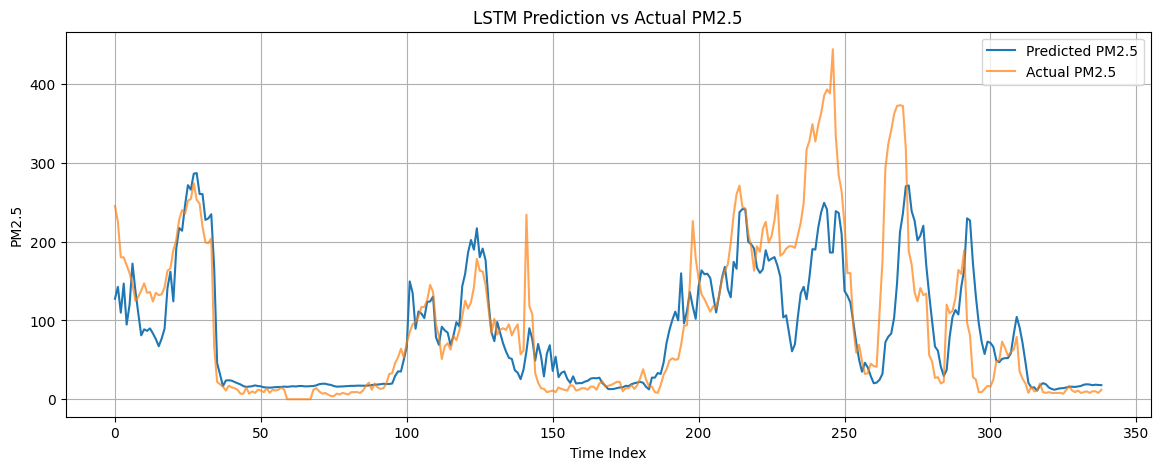

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(predictions, label='Predicted PM2.5')
plt.plot(y_test_seq, label='Actual PM2.5', alpha=0.7)
plt.title('LSTM Prediction vs Actual PM2.5')
plt.xlabel('Time Index')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()